In [1]:
from src.utils.PoNQ import PoNQ
import src.utils.mesh_tools as mt
import torch
from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import knn_points
from meshplot import plot
import matplotlib.pyplot as plt
from tqdm import tqdm
import igl

In [2]:
model_name = 'data/bunny.obj'
GRID_N = 16
device='cpu'

In [3]:
input_points, input_normals = mt.load_shape(model_name, normalize='NDC', sample_n=int(1.5e5*GRID_N**2/32**2))

In [4]:
points = mt.mesh_grid(GRID_N, True)
V = PoNQ(points[mt.mask_relevant_voxels(GRID_N, input_points)], device)

optimizer = torch.optim.Adam([V.points], 1e-3/(GRID_N/32))

tensor_surface = torch.tensor(input_points, dtype=torch.float32).to(device)
tensor_normals = torch.tensor(input_normals, dtype=torch.float32).to(device)
L=[]


In [5]:
def train_simple(V, optimizer, tensor_surface, repulsion_fac=0, sample_fac=1):
    optimizer.zero_grad()
    masks = torch.rand_like(tensor_surface[:, 0]) < sample_fac
    loss = chamfer_distance(
        tensor_surface[masks][None, :], V.points[None, :])[0].mean()
    if repulsion_fac > 0:
        min_dist = knn_points(V.points[None, :], V.points[None, :], K=2).dists[0, :, 1]**2
        loss += -repulsion_fac * min_dist.mean()
    x = loss.item()
    loss.backward()
    optimizer.step()
    return x


100%|██████████| 200/200 [00:05<00:00, 33.42it/s]


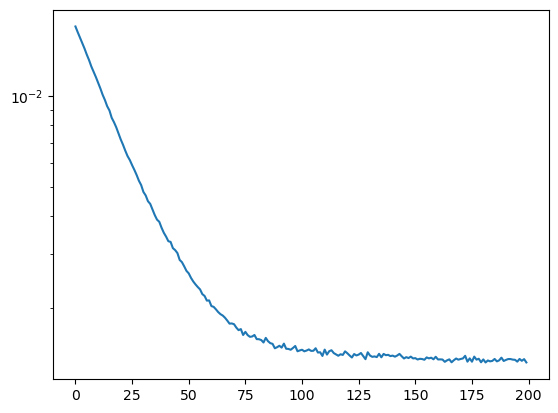

In [6]:
for i in tqdm(range(200)):
    L.append((train_simple(V, optimizer, tensor_surface, repulsion_fac=0, sample_fac=.1)))
plt.plot(L)
plt.yscale('log')

In [7]:
V.cluster_samples_quadrics_normals(tensor_surface, tensor_normals)

In [8]:
plot(*V.quadric_ellipse_mesh())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001126…

In [9]:
plot(*V.min_cut_surface(GRID_N))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001393…

In [10]:
plot(*igl.read_triangle_mesh(model_name))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000117…